# Tarea 2 - INF-493

(a) Defina una función que cargue lea el primer archivo y genere una matriz dispersa Z (preferentemente
una scipy.sparse.csr matrix si trabaja en python) de forma n × d donde n es el número de perfiles
LinkedIn (número de ejemplos en nuestro caso) y d es el número de competencias totales. La entrada
Z ij será 1 si el usuario i posee/declara la competencia j y 0 en otro caso.

In [1]:
import numpy as np
from scipy.sparse import csr_matrix

In [8]:
# Abrir archivos de nombres de skills, contarlas y almacenarlas
labels = []
with open("skill_id", "r") as skills:
    for line in skills:
        label = line.split(" :")
        labels.append(unicode(label[0], "utf-8"))
    d = int(label[1]) + 1
print "Leídas",d,"skills"
# Abrir archivos de skills por perfil de usuario
rows = np.array([], dtype=int)
cols = np.array([], dtype=int)
with open("user_skill", "r") as users:
    n = 0
    for line in users:
        user, str_skills = line.split(":")
        str_skills = str_skills.split(",")
        int_skills =  map(int, str_skills)
        # Definir por usuario las filas y las columnas que contendran data en la matriz sparse
        rows = np.concatenate((rows, np.array([int(user) for i in int_skills])))
        cols = np.concatenate((cols, int_skills))
        n += 1
print "Leídos",n,"perfiles"
# la data tendrá valores 1 para cada par fila columna
data = np.ones(rows.shape[0])

print "Generando matriz dispersa..."
Z = csr_matrix((data, (rows, cols)), shape=(n, d))
print "Matriz generada de tamaño",Z.shape

Leídas 14544 skills
Leídos 7890 perfiles
Generando matriz dispersa...
Matriz generada de tamaño (7890, 14544)


(b) Construya dos sub-matrices, Ztr , Zts , a partir de Z. La primera, de dimensiones n tr ×d corresponderá a
los casos de entrenamiento. La segunda, de dimensiones n ts ×d corresponderá a los casos de pruebas. Los
conjuntos de entrenamiento y pruebas deben ser disjuntos y además n tr + n ts = n. Elija aleatoriamente
los casos de entrenamiento y pruebas, permutando por ejemplo las filas de X antes de la selección.

In [7]:
np.random.seed(20)
indices = np.arange(n)
# Elegir aleatoriamente el tamaño del conjunto de entrenamiento
tr_size =  int(np.random.random() * n)
# Extraer indices de ejemplos de entrenamiento a partir de la lista general de indices
tr_indices = np.random.choice(indices, tr_size, replace=False)
mask = np.ones(indices.shape, dtype=bool)
mask[tr_indices] = False
# Indices de usuarios que quedaron conjunto de prueba
ts_indices = indices[mask]
# Particionamiento
Ztr = Z[tr_indices]
print "Matriz de entrenamiento generada de tamaño",Ztr.shape
Zts = Z[ts_indices]
print "Matriz de prueba generada de tamaño",Zts.shape

Matriz de entrenamiento generada de tamaño (4640, 14544)
Matriz de prueba generada de tamaño (3250, 14544)


(c) Construya un gráfico que muestre el número de usuarios que declaran cada competencia. Deberá elegir
un tipo de gráfico apropiado que haga completamente legible la información que se desea obtener.

Se han definidos dos gráficos para mostrar la cantidad de usuarios que declaran las skills registradas en el conjunto de datos. El primer gráfico es cualitativo, una nube de palabras que muestra las skills con distintos tamaños de fuente. Mientras más grande la fuente, más personas han declarado poseer esa skill.

El segundo gráfico es más cuantitativo y es un clásico histograma de frecuencias que reafirma lo revisado cualitativamente. Por razones de espacio sólo se listan las 15 skills más frecuentes.

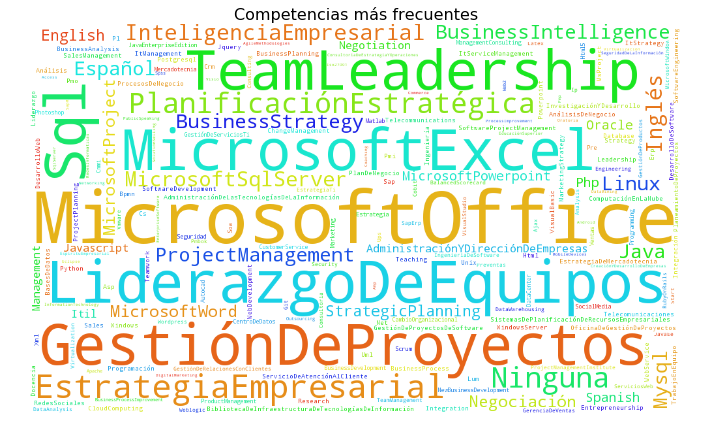

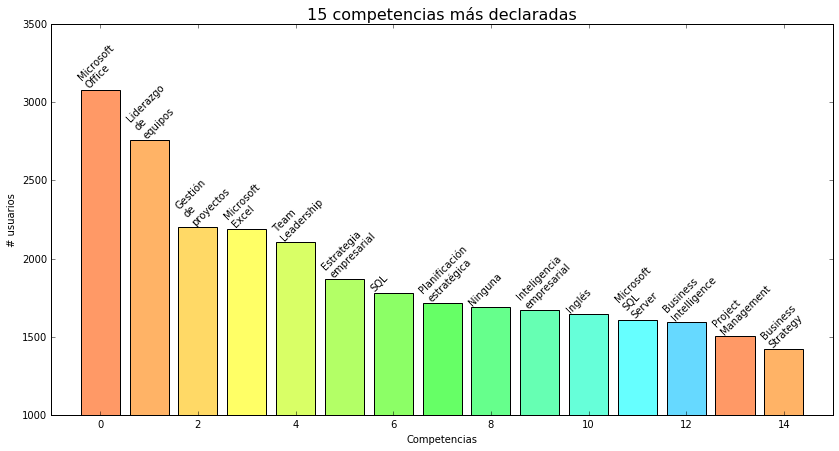

In [10]:
%matplotlib inline

# Graficar data: Nube de palabras y top n skills más frecuentes
# Requiere la herramienta word_cloud disponible desde https://github.com/amueller/word_cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocesar skills para mostrarlas a partir de labels
text = " ".join([labels[i].title().replace(" ", "") for i in cols])
# Generar wordcloud
wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      relative_scaling=0.1, prefer_horizontal=0.7).generate(text)
plt.figure(figsize=(14,7))
plt.title(u"Competencias más frecuentes", fontsize=16)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Contar frecuencia de skills y ordenar decreciente
nmax = 15
freq = np.bincount(cols)
s = np.argsort(freq)[::-1]
freq = freq[s]
plotlabels = np.array(labels)[s]
plotlabels = [label.replace(" ", "\n") for label in plotlabels]
colors = ['#ff9966','#ffb366','#ffd966','#ffff66','#d9ff66','#b3ff66','#8cff66','#66ff66','#66ff8c','#66ffb3', '#66ffd9', '#66ffff', '#66d9ff']
plt.figure(figsize=(14,7))
plt.title(str(nmax)+u' competencias más declaradas', fontsize=16)
rect = plt.bar(np.arange(nmax), freq[0:nmax], bottom=0, align="center", color=colors)
for i in range(nmax):
    plt.text(i-0.5, freq[i] , plotlabels[i], rotation=45, ha='left', va='bottom')
plt.ylabel("# usuarios")
plt.xlabel("Competencias")
plt.ylim([1000, 3500])
plt.xlim([-1,nmax])
plt.show()

In [11]:
# Generar para una skill en especifico el training test y el testing set
myskill = 29
print "Skill elegida:",labels[myskill]
Y = Z[:,myskill].toarray().T[0]
X = csr_matrix(np.delete(Z.toarray(), myskill, 1))

Ytr = Ztr[:,myskill].toarray().T[0]
Xtr = csr_matrix(np.delete(Ztr.toarray(), myskill, 1))

Yts = Zts[:,myskill].toarray().T[0]
Xts = csr_matrix(np.delete(Zts.toarray(), myskill, 1))

Skill elegida: Microsoft Office


In [12]:
# Generar clasificadores para predecir si un usuario tiene la competencia "myskill" o no dadas las demas competencias
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(Xtr, Ytr)
print logreg.score(Xts, Yts)
# OBservacion: Si el conjunto de entrenamiento posee ejemplos solo de una clase el solver reclama! (al menos el logistic regression)

0.707384615385
